In [1]:
import pandas as pd
import numpy as np
from NEExT.NEExT import NEExT
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import xgboost
import plotly.express as px
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, mean_squared_error, precision_score, recall_score
import warnings
from plotly.subplots import make_subplots
import plotly.graph_objects as go
warnings.filterwarnings('ignore')

In [2]:
def build_embedding(dataset_name, feat_name, feat_vect_len):
    edge_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/edge_file.csv"%(dataset_name)
    graph_label_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/graph_label_mapping_file.csv"%(dataset_name)
    node_graph_mapping_file = "https://raw.githubusercontent.com/elmspace/ugaf_experiments_data/main/real_world_graphs/%s/processed_data/node_graph_mapping_file.csv"%(dataset_name)

    nxt = NEExT(quiet_mode="on")
    nxt.load_data_from_csv(edge_file=edge_file, node_graph_mapping_file=node_graph_mapping_file, graph_label_file=graph_label_file)

    nxt.compute_graph_feature(feat_name=feat_name, feat_vect_len=feat_vect_len)
    
    nxt.pool_graph_features(pool_method="concat")
    
    node_ids = nxt.graph_c.global_feature_vector["node_id"]
    graph_ids = nxt.graph_c.global_feature_vector["graph_id"]
    feature = nxt.graph_c.global_feature_vector["feat_"+feat_name+"_"+str(feat_vect_len-1)]
    
    # Filter for a specific node feat len
    df = pd.DataFrame()
    df["node_id"] = node_ids
    df["graph_id"] = graph_ids
    df["feat_"+feat_name+"_"+str(feat_vect_len-1)] = feature
    nxt.graph_c.global_feature_vector = df.copy(deep=True)
    nxt.graph_c.global_feature_vector_cols = ["feat_"+feat_name+"_"+str(feat_vect_len-1)]


    
    nxt.build_graph_embedding(emb_dim_len=1, emb_engine="approx_wasserstein")

    data = nxt.graph_embedding["graph_embedding_df"]
    data = nxt.graph_c.grpah_labels_df.merge(data, on="graph_id")
    data.columns = ["graph_id", "graph_label", feat_name]
    return data

In [3]:
features = ["basic_expansion", "self_walk", "page_rank", "degree_centrality", "closeness_centrality", "load_centrality",
           "eigenvector_centrality", "lsme"]

datasets = ["BZR", "IMDB", "NCI1", "MUTAG", "PROTEINS"]

all_all_res = pd.DataFrame()
for feat_vect_len in tqdm([1, 2, 3, 4], desc="feat_len"):
    
    all_res = pd.DataFrame()
    for dataset_name in datasets:
        
        res = pd.DataFrame()
        for feat_name in features:
                
            df = build_embedding(dataset_name, feat_name, feat_vect_len)
            if res.empty:
                res = df.copy(deep=True)
            else:
                res = res.merge(df, on=["graph_id", "graph_label"])
                
        res["dataset"] = dataset_name
        if all_res.empty:
            all_res = res.copy(deep=True)
        else:
            all_res = pd.concat([all_res, res])

    all_res["feat_len"] = feat_vect_len
    if all_all_res.empty:
        all_all_res = all_res.copy(deep=True)
    else:
        all_all_res = pd.concat([all_all_res, all_res])


feat_len: 100%|█████████████████████████████████████████████████████████████████████████| 4/4 [24:26<00:00, 366.64s/it]


In [4]:
all_all_res

,graph_id,graph_label,basic_expansion,self_walk,page_rank,degree_centrality,closeness_centrality,load_centrality,eigenvector_centrality,lsme,dataset,feat_len
0,0,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.070985,BZR,1
1,1,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,0.012324,BZR,1
2,2,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.096869,BZR,1
3,3,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,-0.107305,BZR,1
4,4,-1,5.839223e-10,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.113180,BZR,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1108,2,-3.690765e-01,0.109909,0.201150,0.195601,0.321649,0.225433,0.223581,-0.001515,PROTEINS,4
1109,1109,2,2.159440e-02,0.062254,-0.577729,-0.555695,-0.425012,-0.181825,-0.328415,0.141617,PROTEINS,4
1110,1110,2,2.882937e-03,0.046296,-0.563832,-0.551371,-0.399817,-0.366948,-0.569554,0.072547,PROTEINS,4
1111,1111,2,-3.690765e-01,0.109909,0.201150,0.195601,0.321649,0.225433,0.223581,-0.001515,PROTEINS,4


In [5]:
all_all_res.to_csv("./data/results.csv", index=False)

# Build Model

In [14]:
ml_data = all_all_res.copy(deep=True)

In [15]:
ml_data

,graph_id,graph_label,basic_expansion,self_walk,page_rank,degree_centrality,closeness_centrality,load_centrality,eigenvector_centrality,lsme,dataset,feat_len
0,0,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.070985,BZR,1
1,1,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,0.012324,BZR,1
2,2,-1,1.946408e-09,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.096869,BZR,1
3,3,-1,4.386578e-09,-0.044379,0.097098,0.079057,0.198728,-0.028358,0.110442,-0.107305,BZR,1
4,4,-1,5.839223e-10,-0.021841,0.216180,0.202306,0.289911,0.026240,0.199050,-0.113180,BZR,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1108,2,-3.690765e-01,0.109909,0.201150,0.195601,0.321649,0.225433,0.223581,-0.001515,PROTEINS,4
1109,1109,2,2.159440e-02,0.062254,-0.577729,-0.555695,-0.425012,-0.181825,-0.328415,0.141617,PROTEINS,4
1110,1110,2,2.882937e-03,0.046296,-0.563832,-0.551371,-0.399817,-0.366948,-0.569554,0.072547,PROTEINS,4
1111,1111,2,-3.690765e-01,0.109909,0.201150,0.195601,0.321649,0.225433,0.223581,-0.001515,PROTEINS,4


In [97]:
def build_classifier(data, dataset, X_cols, y_col):

    results = pd.DataFrame()
    accuracy_list = []
    
    for i in range(30):
        df = data[(data["dataset"] == dataset)].copy(deep=True)    

        dfdfdf = pd.DataFrame()
        all_X_cols = []
        for feat_len in df["feat_len"].unique().tolist():
            dfdf = df[df["feat_len"] == feat_len].copy(deep=True)
            x_cols = []
            for col in dfdf.columns:
                if col in X_cols:
                    x_cols.append(col+"_"+str(feat_len))
                    all_X_cols.append(col+"_"+str(feat_len))
                else:
                    x_cols.append(col)
            dfdf.columns = x_cols
            dfdf = dfdf.drop('dataset', axis=1)
            dfdf = dfdf.drop('feat_len', axis=1)
            
            if dfdfdf.empty:
                dfdfdf = dfdf.copy(deep=True)
            else:
                dfdfdf = dfdfdf.merge(dfdf, on=["graph_id","graph_label"])

        df = dfdfdf.copy(deep=True)
        
        raw_classes = df[y_col].unique().tolist()
        class_map = {}
        class_remap = 0
        for class_val in raw_classes:
            class_map[class_val] = class_remap
            class_remap += 1
        df[y_col] = df[y_col].apply(lambda x: class_map[x])
            
        X = df[all_X_cols]
        y = df[[y_col]]
    
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
    
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)


        # Random Forrest
        model = RandomForestClassifier()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test).flatten()
        accuracy = accuracy_score(y_test, y_pred)
        importances = model.feature_importances_

        
        # # XGBoost
        # model = xgboost.XGBClassifier(n_estimators=500, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
        # model.fit(X_train, y_train)
        # y_pred = model.predict(X_test).flatten()
        # accuracy = accuracy_score(y_test, y_pred)
        # importances = model.feature_importances_


        df = pd.DataFrame()
        df["features"] = all_X_cols
        df["importance"] = importances

        if results.empty:
            results = df.copy(deep=True)
        else:
            results = pd.concat([results, df])    

        accuracy_list.append(accuracy)

    accuracy_df = pd.DataFrame()
    accuracy_df["accuracy"] = accuracy_list
    accuracy_df["dataset"] = dataset

    results["dataset"] = dataset

    return results, accuracy_df

    

In [98]:
feat_NCI1, accuracy_NCI1 = build_classifier(ml_data, dataset="NCI1", X_cols=features, y_col="graph_label")
feat_MUTAG, accuracy_MUTAG = build_classifier(ml_data, dataset="MUTAG", X_cols=features, y_col="graph_label")
feat_IMDB, accuracy_IMDB = build_classifier(ml_data, dataset="IMDB", X_cols=features, y_col="graph_label")
feat_PROTEINS, accuracy_PROTEINS = build_classifier(ml_data, dataset="PROTEINS", X_cols=features, y_col="graph_label")
feat_BZR, accuracy_BZR = build_classifier(ml_data, dataset="BZR", X_cols=features, y_col="graph_label")

accuracy_df = pd.concat([accuracy_NCI1, accuracy_MUTAG, accuracy_IMDB, accuracy_PROTEINS, accuracy_BZR])
feat_importance_df = pd.concat([feat_NCI1, feat_MUTAG, feat_IMDB, feat_PROTEINS, feat_BZR])

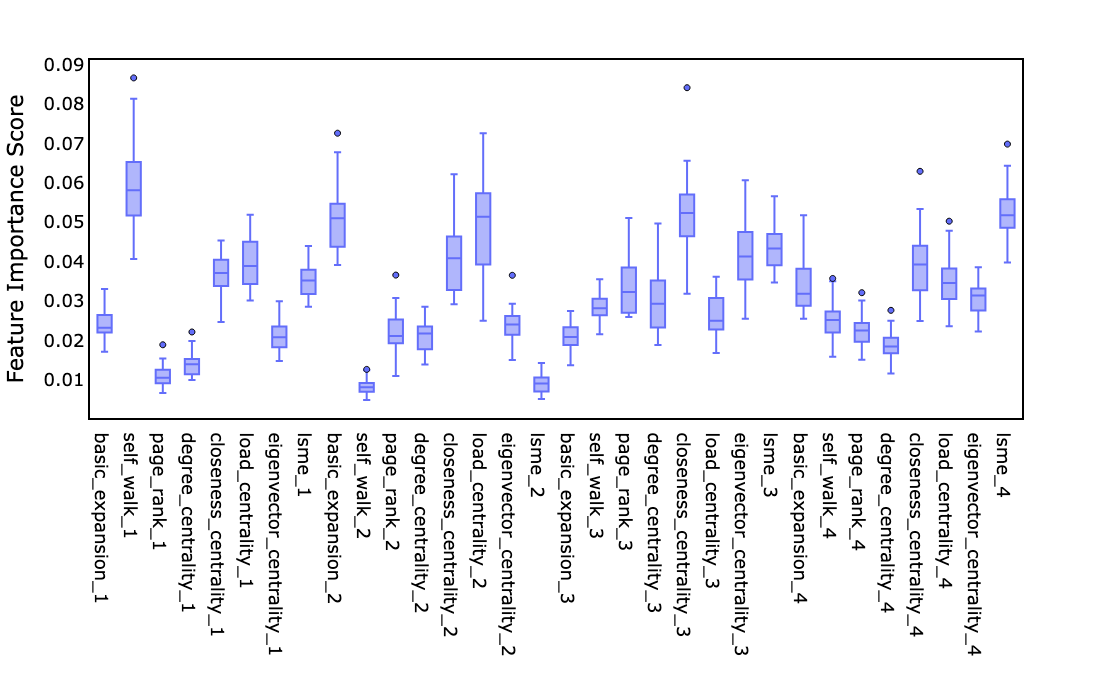

In [99]:
fig = px.box(feat_BZR, x="features", y="importance")

fig.update_layout(paper_bgcolor='white')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(color='black')
fig.update_layout(
    yaxis = dict(
        title = "Feature Importance Score",
        zeroline=True,
        showline = True,
        linecolor = 'black',
        mirror=True,
        linewidth = 2
    ),
    xaxis = dict(
        title = "",
        mirror=True,
        zeroline=True,
        showline = True,
        linecolor = 'black',
        linewidth = 2,
    ),
    width=1100,
    height=700,
    font=dict(
    size=18,
    color="black")  
)
fig.update_layout(showlegend=True)
# fig.update_layout(yaxis_range=[0.0,0.35])
# fig.update_xaxes(showgrid=True, gridwidth=2.0, gridcolor='#e3e1e1')
fig.update_yaxes(showgrid=False, gridwidth=0.5, gridcolor='grey')
fig.update_traces(marker_line_color='black', marker_line_width=1.0, opacity=1.0)

fig.show()

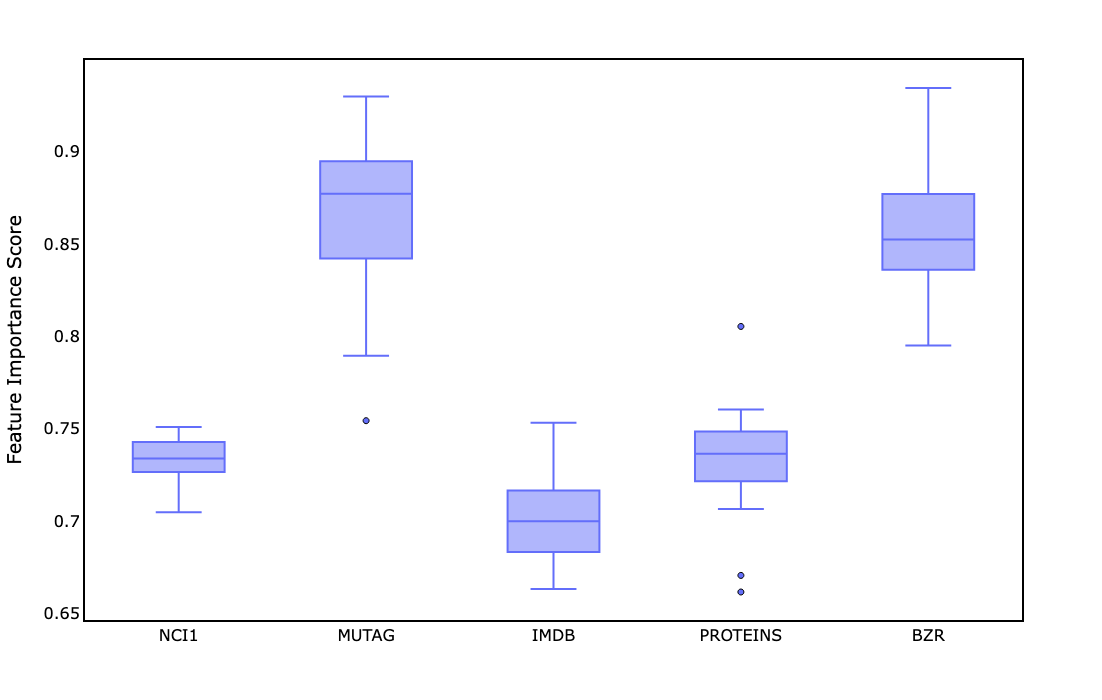

In [100]:
fig = px.box(accuracy_df, x="dataset", y="accuracy")

fig.update_layout(paper_bgcolor='white')
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(color='black')
fig.update_layout(
    yaxis = dict(
        title = "Feature Importance Score",
        zeroline=True,
        showline = True,
        linecolor = 'black',
        mirror=True,
        linewidth = 2
    ),
    xaxis = dict(
        title = "",
        mirror=True,
        zeroline=True,
        showline = True,
        linecolor = 'black',
        linewidth = 2,
    ),
    width=800,
    height=700,
    font=dict(
    size=16,
    color="black")  
)
fig.update_layout(showlegend=True)

# fig.update_layout(legend=dict(
#     yanchor="top",
#     y=0.99,
#     xanchor="left",
#     x=0.85,
#     bgcolor="white",
#     bordercolor="Black",
#     borderwidth=1
# ))

fig.update_xaxes(showgrid=False, gridwidth=0.5, gridcolor='#e3e1e1')
fig.update_yaxes(showgrid=False, gridwidth=0.5, gridcolor='grey')
fig.update_traces(marker_line_color='black', marker_line_width=1.0, opacity=1.0)

fig.show()

In [101]:
accuracy_df.groupby(by=["dataset"]).mean()

,accuracy
dataset,
BZR,0.855738
IMDB,0.701333
MUTAG,0.864327
NCI1,0.731657
PROTEINS,0.734132


In [103]:
feat_importance_df.to_csv("./data/feat_importance.csv", index=False)